## Analyzing Data with Spark
### (Using ClusterData 2011 traces dataset)

In [3]:
# Importing the libraries needed to launch the Spark session and utilize its other functions
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col,desc, avg, corr, max, round, udf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Creating a Spark session
spark = SparkSession.builder.appName("ClusterDataAnalysis").config("spark.driver.memory", "4g") .config("spark.executor.memory", "4g").getOrCreate()

# Defining the file path for the files needed for analysis
machine_events_path = "data/machine_events/part-00000-of-00001.csv"
job_events_path = "data/job_events/part-00000-of-00500.csv"
task_events_path = "data/task_events/part-00000-of-00500.csv"
task_usage_path = "data/task_usage/part-00000-of-00500.csv"

# Reading the CSV files from the specified path
machine_events = spark.read.option("header", "false").csv(machine_events_path)
job_events = spark.read.option("header", "false").csv(job_events_path)
task_events = spark.read.option("header", "false").csv(task_events_path)
task_usage = spark.read.option("header", "false").csv(task_usage_path)

# Selecting only the required columns needed for analysis
machine_events_df = machine_events.select("_c0","_c1", "_c2", "_c4","_c5")
job_events_df  = job_events.select("_c1","_c2", "_c4","_c5")  
task_events_df  = task_events.select("_c0","_c2","_c3", "_c4","_c5", "_c7","_c8","_c9", "_c10") 
task_usage_df = task_usage.select("_c0","_c1","_c2", "_c3","_c4", "_c5", "_c6")

# Renaming columns with appropriate column name as specified in schema.csv of datastet
machine_events_df = machine_events_df.withColumnRenamed("_c0", "machine_timestamp").withColumnRenamed("_c1", "machine_id").withColumnRenamed("_c2", "event_type").withColumnRenamed("_c4", "cpu_capacity").withColumnRenamed("_c5", "memory_capacity")
job_events_df = job_events_df.withColumnRenamed("_c1", "time").withColumnRenamed("_c2", "job_id").withColumnRenamed("_c4", "event_type").withColumnRenamed("_c5", "scheduling_class")
task_events_df = task_events_df.withColumnRenamed("_c0", "task_timestamp").withColumnRenamed("_c2", "job_id").withColumnRenamed("_c3", "task_index").withColumnRenamed("_c4", "machine_id").withColumnRenamed("_c5", "event_type").withColumnRenamed("_c7", "scheduling_class").withColumnRenamed("_c8", "priority").withColumnRenamed("_c9", "cpu_request").withColumnRenamed("_c10", "memory_request")
task_usage_df = task_usage_df.withColumnRenamed("_c0", "start_time").withColumnRenamed("_c1", "end_time").withColumnRenamed("_c2", "job_id").withColumnRenamed("_c3", "task_index").withColumnRenamed("_c4", "machine_id").withColumnRenamed("_c5", "cpu_rate").withColumnRenamed("_c6", "canonical_memory_usage")


### Analyses Conducted:

### 1) What is the distribution of the machines according to their CPU capacity?

+------------+-------------+
|cpu_capacity|machine_count|
+------------+-------------+
|        0.25|          126|
|         0.5|        11659|
|         1.0|          798|
+------------+-------------+



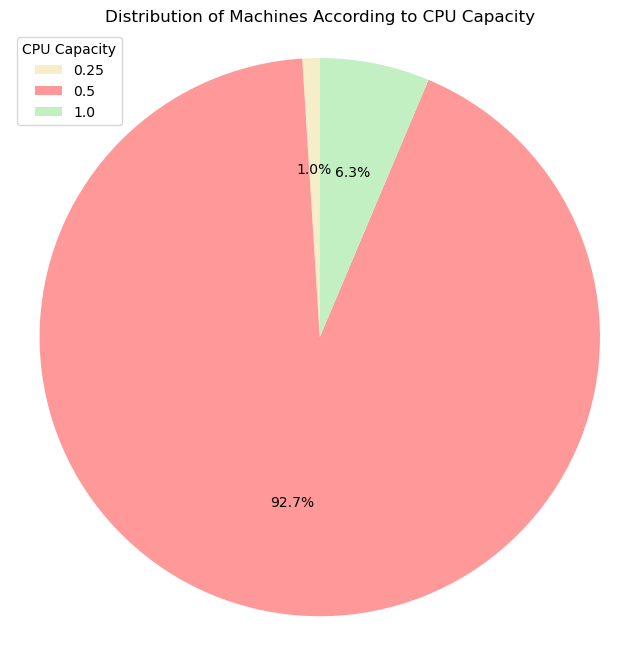

In [100]:
# Filtering out rows whose CPU capacity were not specified
machine_count_by_cpu = machine_events_df.filter(machine_events_df.cpu_capacity.isNotNull())

# Counting the number of machines for each CPU capacity
machine_count_by_cpu = machine_count_by_cpu.groupBy("cpu_capacity").agg(
    F.countDistinct("machine_id").alias("machine_count")
).withColumn("cpu_capacity", col("cpu_capacity").cast("double"))

# Displaying the distribution of machines based on CPU capacity
machine_count_by_cpu.show()

# Converting to a Pandas DataFrame for plotting
machine_count_by_cpu_pd = machine_count_by_cpu.toPandas()

# Plotting the distribution of machines according to CPU capacity as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(machine_count_by_cpu_pd['machine_count'], autopct='%1.1f%%', startangle=90, colors = ['#f5eec9','#ff9999', '#c2f0c2'])
plt.title('Distribution of Machines According to CPU Capacity')
plt.legend(machine_count_by_cpu_pd['cpu_capacity'], title='CPU Capacity', loc='upper left', bbox_to_anchor=(0, 1))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### 2) What is the percentage of computational power lost due to maintenance (a machine went offline and reconnected later)?

In [66]:
# Filtering the offline events (event_type == 1)
offline_events_df = machine_events_df.filter(col("event_type") == 1)

# Calculating the total capacity of machines that went offline
offline_total_capacity_df = offline_events_df.groupBy().agg(
    F.sum("cpu_capacity").alias("offline_total_cpu_capacity"),
    F.sum("memory_capacity").alias("offline_total_mem_capacity")
)

# Calculating the overall total capacity of all machines
total_capacity_df = machine_events_df.groupBy().agg(
    F.sum("cpu_capacity").alias("total_cpu_capacity"),
    F.sum("memory_capacity").alias("total_mem_capacity")
)

# Calculating the percentage of computational power lost due to maintenance
computational_power_loss_df = offline_total_capacity_df.crossJoin(total_capacity_df).withColumn(
    "percent_power_loss",
    (F.col("offline_total_cpu_capacity") + F.col("offline_total_mem_capacity")) * 100 / (F.col("total_cpu_capacity") + F.col("total_mem_capacity"))
)
computational_power_loss_df.show()

# Displaying the percentage result - Computational Loss Due to Maintenance
percentage_computational_power_lost = computational_power_loss_df.select("percent_power_loss").first()[0]
print(f"Percentage of computational loss due to maintenance: {percentage_computational_power_lost:.2f}%")

+--------------------------+--------------------------+------------------+------------------+------------------+
|offline_total_cpu_capacity|offline_total_mem_capacity|total_cpu_capacity|total_mem_capacity|percent_power_loss|
+--------------------------+--------------------------+------------------+------------------+------------------+
|                    4764.0|           4404.2448299995|           19858.0| 17995.85003999888|24.220111878479276|
+--------------------------+--------------------------+------------------+------------------+------------------+

Percentage of computational loss due to maintenance: 24.22%


### 3) What is the distribution of the number of jobs/tasks per scheduling class?
### A) Analysing the distribution of the number of jobs per scheduling class.

+----------------+---------+
|scheduling_class|job_count|
+----------------+---------+
|               3|     1885|
|               0|     2179|
|               1|     3610|
|               2|     3030|
+----------------+---------+



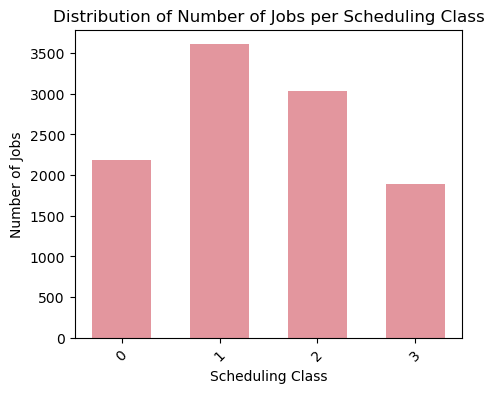

In [46]:
# Filtering the outliers -rows where job_id is not given
job_count_by_scheduling_class = job_events_df.filter(job_events_df["job_id"].isNotNull())

# Counting the number of jobs in each scheduling class
job_count_by_scheduling_class = job_count_by_scheduling_class.groupBy("scheduling_class").agg(
    F.count("job_id").alias("job_count")
)

# Displaying the result, showing the number of jobs for each scheduling class
job_count_by_scheduling_class.show()

# Converting the PySpark DataFrame to a Pandas DataFrame for plotting
job_count_by_scheduling_class_pd = job_count_by_scheduling_class.toPandas()

# Sorting x axis'scheduling_class' in ascending order
job_count_by_scheduling_class_pd = job_count_by_scheduling_class_pd.sort_values(by='scheduling_class')

# Plotting bar chart to see the distribution of the number of jobs per scheduling class
plt.figure(figsize=(5, 4))
plt.bar(job_count_by_scheduling_class_pd['scheduling_class'], job_count_by_scheduling_class_pd['job_count'], width=0.6, color="#e3969e") 
plt.xlabel('Scheduling Class') 
plt.ylabel('Number of Jobs')
plt.title('Distribution of Number of Jobs per Scheduling Class')
plt.xticks(job_count_by_scheduling_class_pd['scheduling_class'], rotation=45)
plt.show()


### 3 B) Analysing the distribution of the number of tasks per scheduling class.

+----------------+----------+
|scheduling_class|task_count|
+----------------+----------+
|               3|     56586|
|               0|    237969|
|               1|     58109|
|               2|     97482|
+----------------+----------+



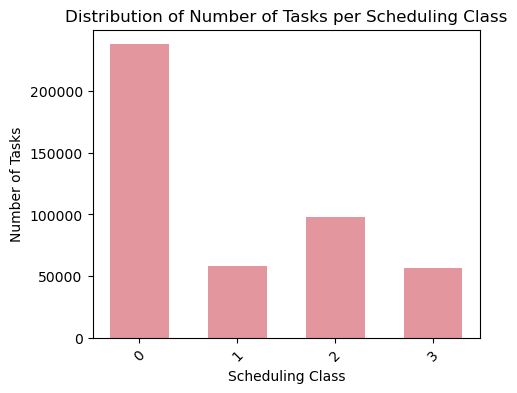

In [52]:
# Adding the DataFrame as temporary SQL table - task_events_table using Spark's inbuilt function
task_events_df.createOrReplaceTempView("task_events_table")

# Using SQL query to filter and aggregate the number of tasks per scheduling class
task_count_by_scheduling_class = spark.sql("""
    SELECT scheduling_class, COUNT(task_index) AS task_count
    FROM task_events_table
    WHERE task_index IS NOT NULL
    GROUP BY scheduling_class
""")

task_count_by_scheduling_class.show()
task_count_by_scheduling_class_pd = task_count_by_scheduling_class.toPandas()

# Sort the DataFrame by 'scheduling_class' in ascending order
task_count_by_scheduling_class_pd  = task_count_by_scheduling_class_pd .sort_values(by='scheduling_class')

# Plotting the data
plt.figure(figsize=(5, 4))
plt.bar(task_count_by_scheduling_class_pd['scheduling_class'], task_count_by_scheduling_class_pd['task_count'],width=0.6, color= "#e3969e") 
plt.xlabel('Scheduling Class') 
plt.ylabel('Number of Tasks') 
plt.title('Distribution of Number of Tasks per Scheduling Class')
plt.xticks(task_count_by_scheduling_class_pd['scheduling_class'], rotation=45)
plt.show() 

### 4) Do tasks with a low scheduling class have a higher probability of being evicted?

+----------------+------------------+
|scheduling_class|evicted_task_count|
+----------------+------------------+
|               0|              2864|
|               1|               792|
|               2|               662|
|               3|                20|
+----------------+------------------+



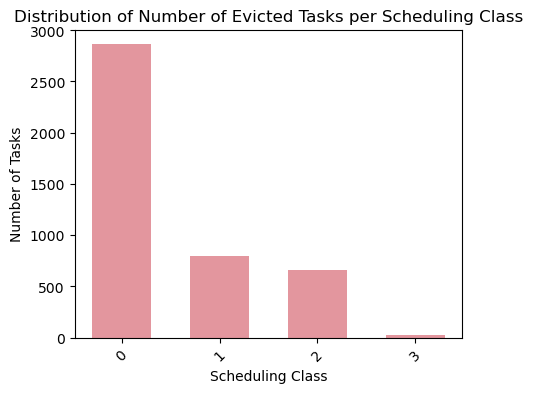

In [58]:
# Using SQL task_events_table to filter rows of event type 2 (evicted) and aggregate data
evicted_tasks_by_scheduling_class = spark.sql("""
    SELECT scheduling_class, COUNT(task_index) AS evicted_task_count
    FROM task_events_table
    WHERE event_type = 2 AND task_index IS NOT NULL
    GROUP BY scheduling_class
    ORDER BY scheduling_class
""")

#Alternate approach without SQL table
#evicted_tasks_df = task_events_df.filter(task_events_df["event_type"] == 2)
#evicted_tasks_by_scheduling_class = evicted_tasks_df.filter(evicted_tasks_df["task_index"].isNotNull()).groupBy("scheduling_class").agg(F.count("task_index").alias("evicted_task_count"))

evicted_tasks_by_scheduling_class.show()
evicted_tasks_by_scheduling_class_pd = evicted_tasks_by_scheduling_class.toPandas()

# Sort the DataFrame by 'scheduling_class' in ascending order
evicted_tasks_by_scheduling_class_pd  = evicted_tasks_by_scheduling_class_pd .sort_values(by='scheduling_class')

# Plotting the data
plt.figure(figsize=(5, 4))
plt.bar(evicted_tasks_by_scheduling_class_pd['scheduling_class'], evicted_tasks_by_scheduling_class_pd['evicted_task_count'],width=0.6, color= "#e3969e") 
plt.xlabel('Scheduling Class') 
plt.ylabel('Number of Tasks') 
plt.title('Distribution of Number of Evicted Tasks per Scheduling Class')
plt.xticks(evicted_tasks_by_scheduling_class_pd['scheduling_class'], rotation=45)
plt.show() 


### 5) In general, do tasks from the same job run on the same machine?

In [67]:
# Collecting the list of machine IDs for each job (same job criteria) in the tasks event
machine_ids_per_job = (
    task_events_df
    .groupBy("job_id")
    .agg(F.collect_list("machine_id").alias("machine_ids_list"))
)

# Filtering jobs utilizing more than one machine
machine_ids_per_job = machine_ids_per_job.filter(F.size("machine_ids_list") > 1)

# Adding a new column 'same_machine_ids_found' based on whether machine IDs are the same for the job considered
machine_ids_per_job = (
     machine_ids_per_job
    .withColumn("same_machine_ids_found", F.size(F.array("machine_ids_list")) == F.size(F.array_distinct("machine_ids_list")))
)
machine_ids_per_job.show()

# Counting the occurrences of True and False in the 'same_machine_ids_found' column
count_true_false = machine_ids_per_job.groupBy("same_machine_ids_found").count()

# Result containing total True/False count indicating as below 
# True - Tasks from the same job run on the same machine
# False - Tasks from the same job run on the different machine
count_true_false.show()



+----------+--------------------+----------------------+
|    job_id|    machine_ids_list|same_machine_ids_found|
+----------+--------------------+----------------------+
|1005246041|[4820073848, 6361...|                 false|
|1015033007|[38643404, 38643404]|                  true|
| 106664144|[2343482865, 4917...|                 false|
|1184713860|[478267324, 66077...|                 false|
|1205597814|[2357745023, 2357...|                  true|
|1223177256|[1429172637, 1429...|                  true|
|1303031391|[38700108, 143667...|                 false|
|1328506354|[38291932, 38291932]|                  true|
|1343463628|[288944632, 28894...|                  true|
|1343463736|[336030154, 33603...|                  true|
|1358321947|[3738987584, 8543...|                 false|
|1369509996|  [1331726, 1331726]|                  true|
|1393056113|[38662459, 577151...|                 false|
|1412625411|[336036420, 20158...|                 false|
| 155171765|[3865219503, 7311..

### 6) Are the tasks that request the more resources the one that consume the more resources?

In [76]:
# Selecting the necessary columns from task_usage_df and task_constraints_df
task_usage_data = task_usage_df.select("job_id", "task_index", "cpu_rate", "canonical_memory_usage")
task_events_data = task_events_df.select("job_id", "task_index", "cpu_request", "memory_request")

# Filtering the outliers of null values
task_usage_data = task_usage_data.filter((F.col("cpu_rate").isNotNull()) & (F.col("canonical_memory_usage").isNotNull()))
task_events_data = task_events_data.filter((F.col("cpu_request").isNotNull()) & (F.col("memory_request").isNotNull()))

# Rounding float values to 3 decimals for CPU and memory usage
task_usage_data = task_usage_data.withColumn("cpu_rate", F.round("cpu_rate", 3))
task_usage_data = task_usage_data.withColumn("canonical_memory_usage", F.round("canonical_memory_usage", 3))
task_events_data = task_events_data.withColumn("cpu_request", F.round("cpu_request", 3))
task_events_data = task_events_data.withColumn("memory_request", F.round("memory_request", 3))

# Sorting in desc order on "cpu_rate" and "canonical_memory_usage" to get the highest usage at top
task_usage_data = task_usage_data.orderBy(desc("cpu_rate"), desc("canonical_memory_usage"))
task_events_data = task_events_data.orderBy(desc("cpu_request"), desc("memory_request"))

print("Task Events Data - Resources Requested:")
task_events_data.show()
print("Task Usage Data - Resources Consumed:")
task_usage_data.show()

# Setting the resource limit dynamically (10% of total records) 
resource_limit_task_usage = int(0.1 * task_usage_data.count())
resource_limit_task_events = int(0.1 * task_events_data.count())

# Considering only the top 10% highest request,consumption
limited_task_usage_data = task_usage_data.limit(resource_limit_task_usage).select("job_id", "task_index")
limited_task_events_data = task_events_data.limit(resource_limit_task_events).select("job_id", "task_index")

# Finding matching values for the tasks that request the more resources the one that consume more resources
matching_values = limited_task_usage_data.intersect(limited_task_events_data)
matching_count = matching_values.count()

# Calculating the percentage of tasks that request the more resources are the one that consume the more resources
percentage_matching = (matching_count / min(resource_limit_task_usage, resource_limit_task_events)) * 100
print(f"Percentage of tasks that request the more resources are the one that consume more resources: {percentage_matching:.2f}%")


Task Events Data - Resources Requested:
+----------+----------+-----------+--------------+
|    job_id|task_index|cpu_request|memory_request|
+----------+----------+-----------+--------------+
|6209468726|         0|        0.5|         0.191|
|6209468726|         0|        0.5|         0.191|
|6226323320|         0|        0.5|         0.151|
|6223149112|         0|        0.5|         0.151|
|6223149112|         1|        0.5|         0.151|
|6223149112|         2|        0.5|         0.151|
|6223149112|         3|        0.5|         0.151|
|6223149112|         4|        0.5|         0.151|
|6223149112|         5|        0.5|         0.151|
|6223149112|         6|        0.5|         0.151|
|6223149112|         7|        0.5|         0.151|
|6250599310|         0|      0.438|         0.162|
|6250599310|         0|      0.438|         0.162|
|6230512715|         0|      0.438|         0.162|
|6236575674|         0|      0.438|         0.162|
|6211896520|        21|      0.438|       

+----------+----------+--------+----------------------+
|    job_id|task_index|cpu_rate|canonical_memory_usage|
+----------+----------+--------+----------------------+
|6119300167|       322|   0.533|                 0.038|
|6119300167|       209|   0.517|                 0.039|
|6119300167|       173|   0.515|                 0.039|
|6119300167|       322|   0.489|                 0.068|
|6119300167|       166|   0.483|                 0.032|
|6184860354|       149|   0.479|                 0.192|
|6119300167|       209|   0.473|                 0.046|
|6119300167|       322|    0.46|                 0.071|
|6186120532|       964|   0.455|                 0.148|
|5501666014|         0|   0.454|                 0.027|
|5501666014|         0|   0.454|                 0.027|
|5501666014|         0|   0.453|                 0.027|
|6119300167|       224|   0.451|                 0.031|
|6119300167|       224|    0.45|                 0.032|
|6119300167|       186|   0.448|                

Percentage of tasks that request the more resources are the one that consume more resources: 28.09%


### 7) Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?

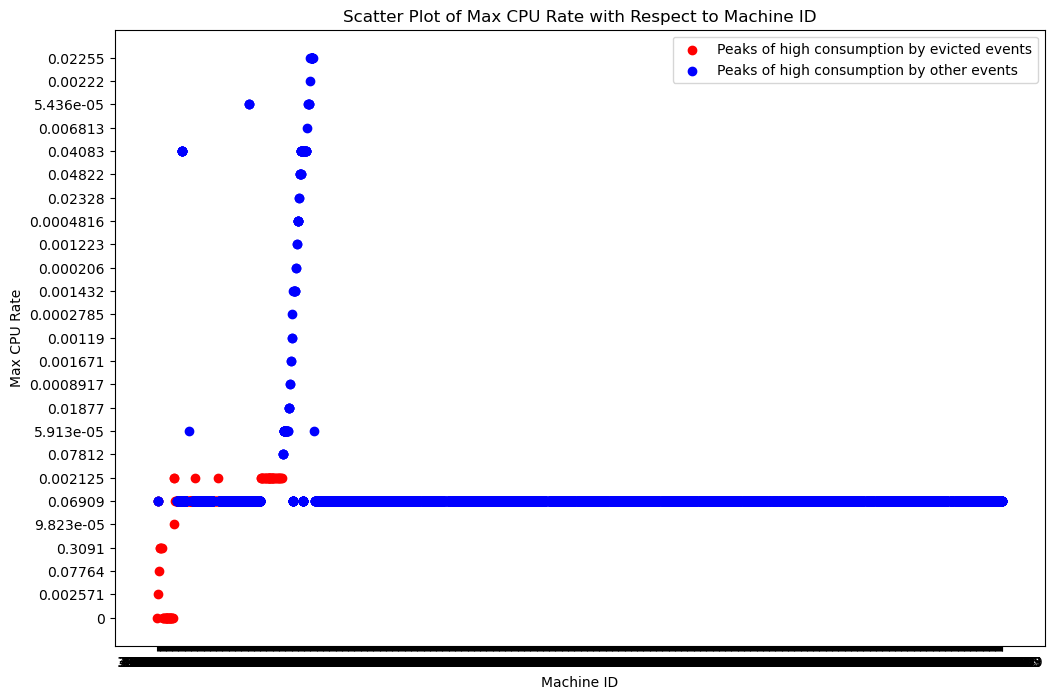

In [101]:
# Filtering the outliers, null values of  machine_id, cpu_rate, canonical_memory_usage
task_events_df = task_events_df.filter(F.col("machine_id").isNotNull())
task_usage_df = task_usage_df.filter((F.col("cpu_rate").isNotNull()) & (F.col("canonical_memory_usage").isNotNull()))

# Selecting required columns and renaming few for distinction
selected_task_events_df = task_events_df.select(
    col("task_timestamp"),
    col("job_id"),
    col("task_index"),
    col("machine_id").alias("task_machine_id"),
    col("event_type").alias("task_event_type") 
)
selected_task_usage_df = task_usage_df.select(
    col("start_time"),
    col("end_time"),
    col("job_id").alias("usage_job_id"),
    col("task_index").alias("usage_task_index"),
    col("machine_id").alias("usage_machine_id"),
    col("cpu_rate"),
    col("canonical_memory_usage")
)

# Joining by using machine_id and the task timestamp that falls inbetween the time machine went offline and online
joined_df = selected_task_usage_df.join(
    selected_task_events_df,
    (selected_task_usage_df["usage_machine_id"] == selected_task_events_df["task_machine_id"]) &
    (selected_task_events_df["task_timestamp"].between(selected_task_usage_df["start_time"], selected_task_usage_df["end_time"])),
    "inner"
)

# Aggregate task_index and taking max(cpu_rate) for each job id , meaning peaks of high resource consumption
grouped_task_ids_cpu_rates = joined_df.groupBy("usage_job_id").agg(
    F.collect_list("usage_task_index").alias("task_index_list"),
    F.expr("max(cpu_rate)").alias("max_cpu_rate")
).withColumnRenamed("usage_job_id", "distinct_job_id")

# Joining with the original DataFrame based on the task index which has the max cpu_rate
final_result_df = joined_df.join(
    grouped_task_ids_cpu_rates,
    (joined_df["usage_job_id"] == grouped_task_ids_cpu_rates["distinct_job_id"]) &
    (F.array_contains(grouped_task_ids_cpu_rates["task_index_list"], joined_df["task_index"])),
    "inner"
)

# Selecting only the required columns from final result of machines with peaks of high consumption
final_result_df = final_result_df.select(
    "task_machine_id",
    "usage_job_id",
    "task_index",
    "max_cpu_rate",
    "task_event_type"
)

# Filtering task_event_type 2 (evicted) with peaks of high consumption
final_result_df_filtered = final_result_df.filter(col("task_event_type") == 2)

#Setting limit 1% of the total records and limitting records to some machine (since dataset is huge)
limit_1 = int(0.01 * final_result_df.count())
final_result_df = final_result_df.limit(limit_1)
limit_2 = int(0.01 * final_result_df_filtered.count())
final_result_df_filtered = final_result_df_filtered.limit(limit_2)

# Converting the DataFrames to Pandas for plotting
final_result_df_filtered_pd = final_result_df_filtered.toPandas()
final_result_df_pd = final_result_df.toPandas()

# Plotting the final correlation peaks of high resource consumption among all task and in which evicted events occur
plt.figure(figsize=(12, 8))

# Scatter plot with red color indicating peaks of high consumption by evicted events in machine
plt.scatter(
    final_result_df_filtered_pd["task_machine_id"],
    final_result_df_filtered_pd["max_cpu_rate"],
    c='red',
    label="Peaks of high consumption by evicted events"
)
# Scatter plot with blue color indicating peaks of high consumption by other events in machine
plt.scatter(
    final_result_df_pd["task_machine_id"],
    final_result_df_pd["max_cpu_rate"],
    c='blue',
    label="Peaks of high consumption by other events"
)
plt.xlabel("Machine ID")
plt.ylabel("Max CPU Rate")
plt.title("Scatter Plot of Max CPU Rate with Respect to Machine ID")
plt.legend()
plt.show()


### Addtional Questions Proposed 
### 1) Do tasks of latency sensitive scheduling class, have greater average memory and CPU requests than other scheduling classes?

Average CPU Request per Scheduling Class:
+----------------+-------------------+
|scheduling_class|average_cpu_request|
+----------------+-------------------+
|               3|              0.086|
|               0|             0.0269|
|               1|             0.0427|
|               2|             0.0603|
+----------------+-------------------+

Average Memory Request per Scheduling Class:
+----------------+----------------------+
|scheduling_class|average_memory_request|
+----------------+----------------------+
|               3|                0.0638|
|               0|                 0.028|
|               1|                0.0285|
|               2|                0.0369|
+----------------+----------------------+



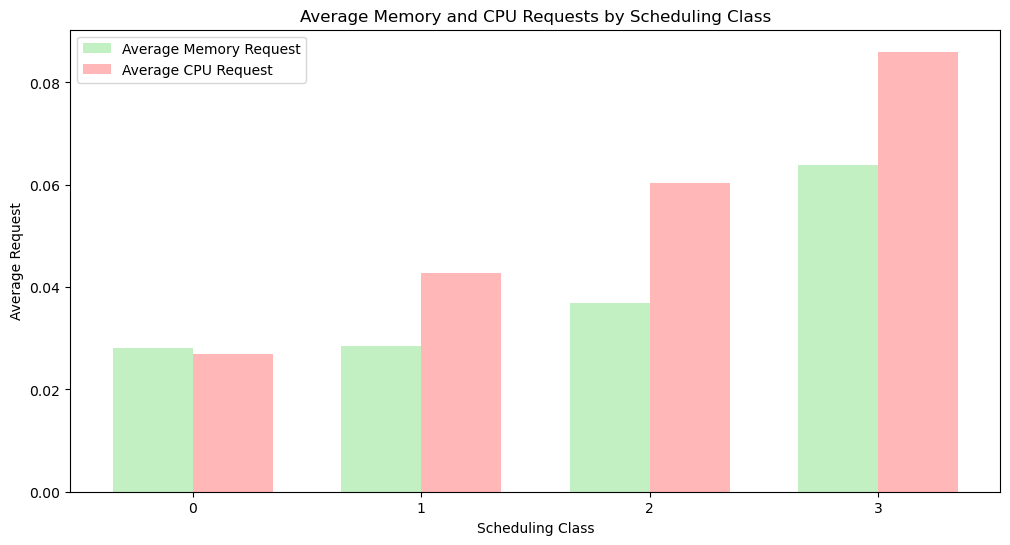

In [102]:
# Calculating the average CPU and memory request per scheduling class from the task_events_df DataFrame
average_cpu_request_df = task_events_df.groupBy("scheduling_class") \
    .agg(round(avg("cpu_request"), 4).alias("average_cpu_request"))

average_memory_request_df = task_events_df.groupBy("scheduling_class") \
    .agg(round(avg("memory_request"), 4).alias("average_memory_request"))

# Displaying the average CPU and memory requests per scheduling class
print("Average CPU Request per Scheduling Class:")
average_cpu_request_df.show()
print("Average Memory Request per Scheduling Class:")
average_memory_request_df.show()

# Converting the Spark DataFrame to Pandas for plotting
memory_request_df = average_memory_request_df.toPandas()
memory_request_df = memory_request_df.sort_values(by='scheduling_class')
cpu_request_df = average_cpu_request_df.toPandas()
cpu_request_df = cpu_request_df.sort_values(by='scheduling_class')

# Plotting the data of average resource (CPU, memory) consumption per scheduling class
bar_width = 0.35
index = np.arange(len(memory_request_df["scheduling_class"]))
plt.figure(figsize=(12, 6))
# Plotting average memory request
plt.bar(index, memory_request_df["average_memory_request"], bar_width, label='Average Memory Request', color='#c2f0c2')
# Shifting the index for plotting the second set of bars
index_shifted = index + bar_width
# Plotting average CPU request
plt.bar(index_shifted, cpu_request_df["average_cpu_request"], bar_width, label='Average CPU Request', alpha=0.7, color='#ff9999')
plt.xlabel('Scheduling Class')
plt.ylabel('Average Request')
plt.title('Average Memory and CPU Requests by Scheduling Class')
plt.xticks(index + bar_width / 2, memory_request_df["scheduling_class"])
plt.legend()
plt.show()

### 2) How much percentage of tasks were killed simply because of the machine being unavailable (due to maintenance or repair)?

Total number of tasks killed: 42456
Total number of tasks killed when machine was offline: 1935
Percentage of tasks killed when machine was offline: 4.56%


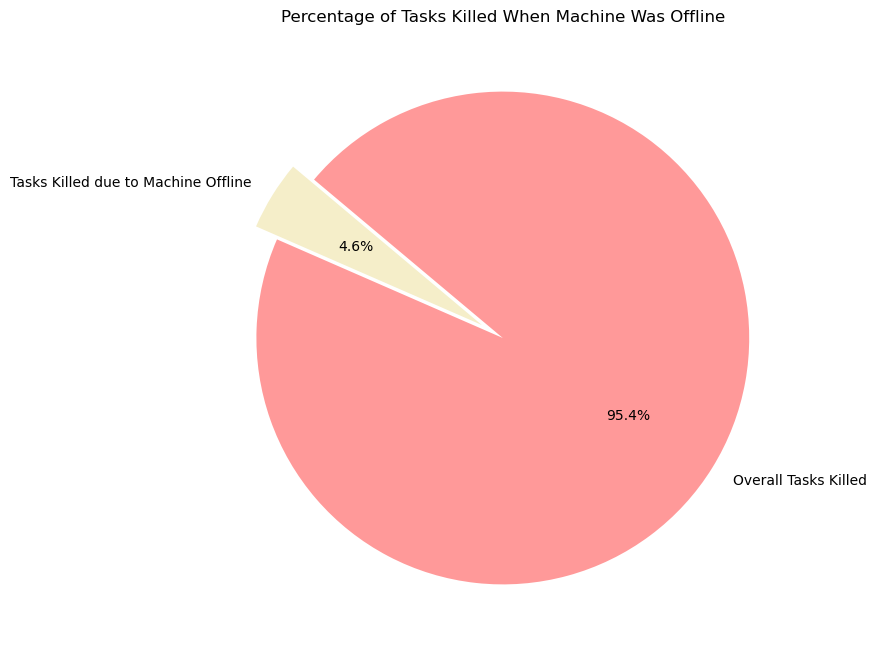

In [103]:
# Selecting necessary columns for analysis
selected_task_events_df = task_events_df.select(
    col("job_id"),
    col("task_index"),
    col("machine_id").alias("task_machine_id"),
    col("event_type").alias("task_event_type")  # Rename event_type to task_event_type
)
selected_machine_events_df = machine_events_df.select(
    col("machine_timestamp"),
    col("machine_id"),
    col("event_type").alias("machine_event_type")  # Rename event_type to machine_event_type
)
selected_task_usage_df = task_usage_df.select(
    col("start_time"),
    col("end_time"),
    col("job_id").alias("usage_job_id"),
    col("task_index").alias("usage_task_index"),
    col("machine_id").alias("usage_machine_id")
)

# Joining the task events with task usage to consider only the jobs with respective tasks that were utilized
task_joined_df = selected_task_events_df.join(
    selected_task_usage_df,
    (selected_task_events_df["job_id"] == selected_task_usage_df["usage_job_id"]) &
    (selected_task_events_df["task_index"] == selected_task_usage_df["usage_task_index"]),
    "inner"
)

# Filtering  task event_type = 5 for considering the killed tasks
filtered_task_events_df = task_joined_df.filter((col("task_event_type") == 5) & (col("usage_machine_id").isNotNull()))

# Filtering machine event_type = 1 (offline) and event_type = 0(available)
offline_machine_events_df = selected_machine_events_df.filter((col("machine_event_type") == 1) | (col("machine_event_type") == 0))

# Extracting the offline start and end timestamps (end meaning its available back)
offline_start_timestamp = offline_machine_events_df.filter(col("machine_event_type") == 1).select("machine_timestamp").collect()[0][0]
offline_end_timestamp = offline_machine_events_df.filter(col("machine_event_type") == 0).select("machine_timestamp").collect()[0][0]

# Joining based on machine id and task timestamp that fall between machine offline and online timeframe
joined_df = filtered_task_events_df.join(
    offline_machine_events_df,
    (filtered_task_events_df["task_machine_id"] == offline_machine_events_df["machine_id"]) &
    (offline_machine_events_df["machine_timestamp"].between(filtered_task_events_df["start_time"], filtered_task_events_df["end_time"])),
    "inner"
)

# Selecting only required columns
result_df = joined_df.select(
    "job_id",
    "task_index",
    "machine_id",
    "task_event_type",
    "machine_event_type"
)

# Counting the total number of tasks which were killed and number of tasks killed when the machine was offline
killed_task_count = filtered_task_events_df.select("task_index").count()
killed_task_machine_offline = result_df.select("task_index").count()

print(f"Total number of tasks killed: {killed_task_count}")
print(f"Total number of tasks killed when machine was offline: {killed_task_machine_offline}")

# Calculating the percentage
percentage_tasks_killed_offline = (killed_task_machine_offline / killed_task_count) * 100
print(f"Percentage of tasks killed when machine was offline: {percentage_tasks_killed_offline:.2f}%")

# Visualizing the result using a pie chart
labels = ['Tasks Killed due to Machine Offline', 'Overall Tasks Killed']
sizes = [killed_task_machine_offline, killed_task_count - killed_task_machine_offline]
colors = ['#f5eec9', '#ff9999']
explode = (0.1, 0)
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Tasks Killed When Machine Was Offline')
plt.show()


### Stop the Spark session to release resources

In [40]:
# Stop Spark session
spark.stop()